# Deepfake and Real Audio Detection System

## Data Loading
The data is already split up in to training, validation and test sets, which contains folders of fake and real
Each sample is a 2 second clip, balanced in terms of gender and class.
Data is also normalised in terms of sample rate, volume and number of channels

In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf

def load_data_from_folder(base_path):
    """
    Args:
      base_path: root folder containing subfolders 'training', 'validation', 'testing'
    Returns:
      dict with keys 'training','validation','testing', each a tuple
      (features, labels, filenames) where:
        - features: np.ndarray, shape (N, L), dtype float32
        - labels:   np.ndarray, shape (N,),    dtype int32
        - filenames: list of file paths
    """
    target_length = int(16000 * 2.0)  # 2 seconds at 16kHz
    label_map = {"fake": 0, "real": 1}
    out = {}
    for split in ['training', 'validation', 'testing']:
        data, labels, files = [], [], []
        split_path = os.path.join(base_path, split)
        for class_name in ['fake', 'real']:
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
            for fname in sorted(os.listdir(class_path)):
                if not fname.endswith('.wav'):
                    continue
                path = os.path.join(class_path, fname)
                # 1) load + resample
                y, sr = librosa.load(path, sr=16000)  
                
                # Ensure all audio samples are the same length (pad or trim)
                if len(y) > target_length:
                    y = y[:target_length]
                elif len(y) < target_length:
                    y = np.pad(y, (0, target_length - len(y)), 'constant')
                
                data.append(y)
                labels.append(label_map[class_name])
                files.append(path)
                
        # stack into (N, L) shape, cast to float32
        X = np.stack(data, axis=0).astype('float32')
        y = np.array(labels, dtype='int32')
        out[split] = (X, y, files)
    return out

def create_tf_datasets(data_dict, batch_size=32):
    """
    Create TensorFlow datasets from the loaded data dictionary.
    Memory-efficient implementation that avoids OOM errors when dealing with large audio files.
    
    Args:
        data_dict: Dictionary with 'training', 'validation', 'testing' splits
        batch_size: Batch size for the datasets
        
    Returns:
        Dictionary with TensorFlow datasets for each split
    """
    datasets = {}
    
    for split in ['training', 'validation', 'testing']:
        if split not in data_dict:
            continue
            
        features, labels, _ = data_dict[split]
        
        # Convert to list of individual examples to avoid loading all data into memory at once
        feature_list = [features[i] for i in range(len(features))]
        label_list = [labels[i] for i in range(len(labels))]
        
        # Generator function to yield one sample at a time to avoid memory issues
        def generator():
            for i in range(len(feature_list)):
                # Add channel dimension for RawNet (expects shape [None, 1])
                yield feature_list[i][..., np.newaxis], label_list[i]
        
        # Get output shapes and types
        output_shapes = (
            tf.TensorShape([None, 1]),  # Variable length audio with 1 channel
            tf.TensorShape([])          # Scalar label
        )
        output_types = (tf.float32, tf.int32)
        
        # Create dataset from generator
        ds = tf.data.Dataset.from_generator(
            generator,
            output_types=output_types,
            output_shapes=output_shapes
        )
        
        # Apply dataset transformations
        if split == 'training':
            # Shuffle training data (with smaller buffer size to save memory)
            buffer_size = min(len(feature_list), 1000)  # Limit buffer size
            ds = ds.shuffle(buffer_size=buffer_size)
            ds = ds.batch(batch_size)
            ds = ds.prefetch(tf.data.AUTOTUNE)
        else:
            ds = ds.batch(batch_size)
            ds = ds.prefetch(tf.data.AUTOTUNE)
            
        datasets[split] = ds
        
    return datasets

2025-05-19 06:20:57.011580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747635657.024996     250 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747635657.029177     250 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = "for-2seconds"
data = load_data_from_folder(path)

In [ ]:
# Print data shapes before creating datasets
training_features, training_labels, train_files = data['training']
validation_features, validation_labels, val_files = data['validation']
test_features, test_labels, test_files = data['testing']

print("Train features shape:", training_features.shape, training_features.dtype)
print("Train labels shape:", training_labels.shape, training_labels.dtype)

In [3]:
batch_size = 32
print(f"Using batch size: {batch_size}")

# Create TensorFlow datasets with memory-efficient approach
try:
    datasets = create_tf_datasets(data, batch_size=batch_size)
    
    train_ds = datasets['training']
    validation_ds = datasets['validation']
    test_ds = datasets['testing']
    
    # Verify dataset shapes
    for x, y in train_ds.take(1):
        print(f"Input batch shape: {x.shape}")
        print(f"Label batch shape: {y.shape}")
        
    print("Dataset creation successful!")
except Exception as e:
    print(f"Error creating datasets: {e}")
    print("If you're still having memory issues, try further reducing batch_size or implementing dataset streaming.")

Using batch size: 32
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


I0000 00:00:1747635707.658564     250 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1880 MB memory:  -> device: 0, name: NVIDIA A16-4Q, pci bus id: 0000:02:0d.0, compute capability: 8.6


Input batch shape: (32, 32000, 1)
Label batch shape: (32,)
Dataset creation successful!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

def test_data_loader_with_spectrogram(data, sr=16000):
    """
    Displays waveform and spectrogram for first and last samples in the training set.
    - data: dict with 'training' → (features, labels, filenames)
    - sr: sample rate (Hz) to use for time/frequency axes
    """
    features, labels, files = data['training']
    samples = [
        ("First", features[0], labels[0]),
        ("Last",  features[-1], labels[-1])
    ]

    for title, audio, label in samples:
        # Time axis
        duration = len(audio) / sr
        t = np.linspace(0, duration, len(audio))

        # 1) Waveform
        plt.figure(figsize=(8, 2))
        plt.plot(t, audio, linewidth=0.8)
        plt.title(f"{title} Sample Waveform")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()

        # 2) Spectrogram
        plt.figure(figsize=(8, 2))
        Pxx, freqs, bins, im = plt.specgram(
            audio, NFFT=1024, Fs=sr, noverlap=512, cmap='viridis'
        )
        plt.title(f"{title} Sample Spectrogram")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.colorbar(im).set_label('Intensity [dB]')
        plt.tight_layout()
        plt.show()

        # 3) Playback
        display(Audio(audio, rate=sr))

# Example usage:
test_data_loader_with_spectrogram(data, sr=16000)

In [6]:
# Testing sizes
print(training_features.shape, training_labels.shape) # Needs to be 13956
print(validation_features.shape, validation_labels.shape) # Needs to be 2826
print(test_features.shape, test_labels.shape) # Needs to be 1088


(13956, 32000) (13956,)
(2826, 32000) (2826,)
(1088, 32000) (1088,)


## Data Augmentation (Only-if you deem necessary) - If results show overfitting, add some augmentation
Potentially adding some noise, pitch shifting, we have 7 hours of audio. Dont think augmentation would be necessary, so yea

## Model
### Use your designated approach
Use a Waveform based 1D CNN (research into CNN architectures that are used for noise recognition)
Paper: https://arxiv.org/pdf/2004.00526
Paper modifies the RawNet Model. We will implement some of the same modifications and tweak a few things of our own
If possible, we could compare the two branched models from the RawNet on our data set and see what the differences in performance.

The aim to to defer from the Original RawNet architecture, add slight adjustments and see 

1. But with this dataset we will use binary cross entropy instead of CCE
2. We are using a different data set here. OG used VoxCeleb1, paper used VoxCeleb2'
3. We will use a attention mechanism alongside GRU layer, (they created a self-attention layer to replace GRU layers)
4. Lastly we will compare out EER to their EER


In [81]:
from tensorflow.keras import layers, models, regularizers

def small_rawnet_reg(input_shape=(None, 1),
                     gru_units=64,
                     l2=1e-4,
                     dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape, name="input_waveform")

    # 1) Initial Conv layer (fewer filters) + Dropout
    x = layers.Conv1D(
          16, 3, strides=2, padding='same', use_bias=False,
          kernel_regularizer=regularizers.l2(l2)
        )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.3)(x)
    x = layers.Dropout(dropout_rate, name="drop_initial")(x)

    # 2) Simple residual block (optional) + Dropout inside
    def res_block(x, filters, stride=1):
        shortcut = x
        y = layers.Conv1D(
              filters, 3, strides=stride, padding='same', use_bias=False,
              kernel_regularizer=regularizers.l2(l2)
            )(x)
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU(negative_slope=0.3)(y)

        y = layers.Conv1D(
              filters, 3, padding='same', use_bias=False,
              kernel_regularizer=regularizers.l2(l2)
            )(y)
        y = layers.BatchNormalization()(y)

        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv1D(
                          filters, 1, strides=stride, use_bias=False,
                          kernel_regularizer=regularizers.l2(l2)
                       )(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.Add()([y, shortcut])
        y = layers.LeakyReLU(negative_slope=0.3)(y)
        return layers.Dropout(dropout_rate)(y)

    x = res_block(x, 32, stride=2)
    x = res_block(x, 64, stride=2)

    # 3) Time downsampling conv + Dropout
    x = layers.Conv1D(
          64, 3, strides=8, padding="same", use_bias=False,
          kernel_regularizer=regularizers.l2(l2),
          name="time_down_conv"
        )(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.3)(x)
    x = layers.Dropout(dropout_rate, name="drop_downsample")(x)

    # 4) Bidirectional GRU with sequences, with recurrent dropout
    x = layers.Bidirectional(
          layers.GRU(
            gru_units,
            return_sequences=True,
            kernel_regularizer=regularizers.l2(l2),
            recurrent_regularizer=regularizers.l2(l2),
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
          ),
          name="bidir_gru_seq"
        )(x)

    # 5) Multi-Head Self Attention + Dropout
    attn_output = layers.MultiHeadAttention(
                    num_heads=4,
                    key_dim=64,
                    kernel_regularizer=regularizers.l2(l2),
                    name="self_attention"
                  )(query=x, value=x, key=x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(name="attn_norm")(x)
    x = layers.Dropout(dropout_rate, name="drop_attn")(x)

    # 6) Pool over time
    x = layers.GlobalAveragePooling1D(name="time_pool")(x)

    # 7) Final Dense for binary output (with L2)
    out = layers.Dense(
            1,
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(l2),
            name='output'
          )(x)

    return models.Model(inputs, out, name='small_rawnet_reg')

# Build and inspect
small = small_rawnet_reg((None,1), gru_units=64)
small.summary()

Model: "small_rawnet_reg"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_waveform      │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_168 (Conv1D) │ (None, None, 16)  │         48 │ input_waveform[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 16)  │         64 │ conv1d_168[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_128     │ (None, None, 16)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_initial        │ (None, None, 16)  │          0 │ leaky_re_lu_128[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_169 (Conv1D) │ (None, None, 32)  │      1,536 │ drop_initial[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 32)  │        128 │ conv1d_169[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_129     │ (None, None, 32)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_170 (Conv1D) │ (None, None, 32)  │      3,072 │ leaky_re_lu_129[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_171 (Conv1D) │ (None, None, 32)  │        512 │ drop_initial[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 32)  │        128 │ conv1d_170[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 32)  │        128 │ conv1d_171[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_70 (Add)        │ (None, None, 32)  │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_130     │ (None, None, 32)  │          0 │ add_70[0][0]      │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, None, 32)  │          0 │ leaky_re_lu_130[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_172 (Conv1D) │ (None, None, 64)  │      6,144 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_172[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_131     │ (None, None, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 221,681 (865.94 KB)

 Trainable params: 220,945 (863.07 KB)

 Non-trainable params: 736 (2.88 KB)

In [80]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
train_time = 20

class TrainForTime(keras.callbacks.Callback):
    """callback to terminate training after a time limit is reached

    Can be used to control how long training runs for, and will terminate
    training once a specified time limit is reached.
    """
    def __init__(
        self,
        train_time_mins=15,
    ):
        super().__init__()

        self.train_time_mins = train_time_mins
        self.epochs = 0
        self.train_time = 0
        self.end_early = False

    def on_train_begin(self, logs=None):
        # save the start time
        self.start_time = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        current_time = tf.timestamp()
        training_time = (current_time - self.start_time)
        if (training_time / 60) > self.train_time_mins:
            self.train_time = current_time - self.start_time
            self.model.stop_training = True
            self.end_early = True


    def on_train_end(self, logs=None):
        if self.end_early:
            print('training time exceeded and ending early')
            print(f'training ended on epoch {self.epochs}')
            print(f'training time = {self.train_time / 60} mins')

# Set up the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor the validation loss
    patience=10,              # Stop after 10 epochs of no improvement
    mode='min',               # 'min' means the training will stop when the val_loss stops decreasing
    verbose=1,                # Print a message when training stops
    restore_best_weights=True # Restore the best model weights when training stops
)

# Set up the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'model_attn_dropouts.keras',                # Path where the model will be saved
    monitor='val_loss',             # Monitor validation loss (can also use 'val_accuracy')
    save_best_only=True,            # Only save the model if it improves
    mode='min',                     # 'min' means the model with the minimum validation loss will be saved
    verbose=1                        # Prints out when the model is saved
)

checkpoint2 = ModelCheckpoint(
    filepath='model_attn_epoch_{epoch:02d}.keras',  # include epoch in filename
    monitor='val_loss',
    save_best_only=False,     # save every epoch, not only the best
    mode='auto',              # 'auto' will infer min/max from the monitored metric
    verbose=1
)

In [82]:
import time
# Train the model with both callbacks

small.compile(
    optimizer='adam',
    loss = {
        'output': 'binary_crossentropy',
    },
    #loss_weights = loss_weights,
    metrics = {
        'output': 'accuracy'
    })

start_time = time.time()
history = small.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=30,
    batch_size=32,                       
    verbose=True,
    callbacks=[checkpoint, TrainForTime(train_time),early_stopping]
)
end_time = time.time()
training_time = end_time - start_time
print(f"Time Took to Train: {training_time}")

Epoch 1/30
     34/Unknown 58s 2s/step - accuracy: 0.6017 - loss: 0.7595
Epoch 1: val_loss improved from inf to 2.44685, saving model to model_attn_dropouts.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.6037 - loss: 0.7573 - val_accuracy: 0.5000 - val_loss: 2.4468
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7895 - loss: 0.5239
Epoch 2: val_loss did not improve from 2.44685
34/34 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7905 - loss: 0.5224 - val_accuracy: 0.5000 - val_loss: 3.3656
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8732 - loss: 0.3806
Epoch 3: val_loss did not improve from 2.44685
34/34 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8738 - loss: 0.3791 - val_accuracy: 0.5000 - val_loss: 5.1405
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8721 - loss: 0.3671
Epoch 4: val_loss improved from 2.44685 to 2.41277, saving model to model_attn_dropouts.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.87

## Testing Performance Using Test Set
- Ensure we test inference time
- Training Time
- Binary classification we can use confusion matrix
- F1, precision, recall and accuracy
- We also need to find the EER as this is a popular metric in biometrics

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve

def compute_eer(y_true, y_scores):
    # y_true: binary labels (0 for negative, 1 for positive)
    # y_scores: model’s positive-class scores (probabilities, logits, etc.)

    # 1) Compute FPR, TPR at all thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # 2) Compute FRR = 1 - TPR
    fnr = 1 - tpr

    # 3) Find the threshold where |FPR - FNR| is minimal
    idx = np.nanargmin(np.abs(fnr - fpr))
    eer = (fpr[idx] + fnr[idx]) / 2  # you can average or just take fpr[idx]

    return eer, thresholds[idx]
        
def evaluate_model(model_path, train_ds, test_ds, threshold=0.5):
    """
    Loads a Keras model, evaluates on the train and test datasets, 
    prints confusion matrices and metrics, and reports inference time.
    """
    # Load the model
    model = load_model(model_path)

    # Helper to extract features and labels from a tf.data.Dataset
    def unpack_dataset(dataset):
        X_list, y_list = [], []
        for x_batch, y_batch in dataset:
            X_list.append(x_batch.numpy())
            y_list.append(y_batch.numpy())
        X = np.concatenate(X_list, axis=0)
        y = np.concatenate(y_list, axis=0).flatten()
        return X, y

    # Unpack train and test datasets
    X_train, y_train = unpack_dataset(train_ds)
    X_test, y_test = unpack_dataset(test_ds)

    # Measure inference time on test set
    import time
    start_time = time.time()
    y_test_probs = model.predict(X_test, verbose=0)
    end_time = time.time()

    # Convert probabilities to binary predictions
    y_train_pred = (model.predict(X_train) >= threshold).astype(int).flatten()
    y_test_pred  = (y_test_probs.flatten() >= threshold).astype(int)

    # Compute metrics
    acc_test = accuracy_score(y_test, y_test_pred)
    report_test = classification_report(y_test, y_test_pred, digits=4)

    # Print test set metrics
    print(f"Accuracy on test set: {acc_test:.4f}")
    print("\nClassification Report (Test):")
    print(report_test)
    print(f"Inference Time (total): {end_time - start_time:.4f} seconds")
    print(f"Inference Time (per sample): {(end_time - start_time)/len(y_test):.6f} seconds")

    # Plot confusion matrices side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    ConfusionMatrixDisplay.from_predictions(
        y_train, y_train_pred, normalize='true', ax=axes[0]
    )
    axes[0].set_title(f'Train Confusion Matrix\nAccuracy: {accuracy_score(y_train, y_train_pred):.4f}')

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_test_pred, normalize='true', ax=axes[1]
    )
    axes[1].set_title(f'Test Confusion Matrix\nAccuracy: {acc_test:.4f}')

    plt.tight_layout()
    plt.show()
    

    eer, eer_threshold = compute_eer(y_test,y_test_probs)
    print(f"EER = {eer*100:.2f}% at threshold {eer_threshold:.3f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
Accuracy on test set: 0.9678

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9722    0.9632    0.9677       544
           1     0.9636    0.9724    0.9680       544

    accuracy                         0.9678      1088
   macro avg     0.9679    0.9678    0.9678      1088
weighted avg     0.9679    0.9678    0.9678      1088

Inference Time (total): 1.9692 seconds
Inference Time (per sample): 0.001810 seconds


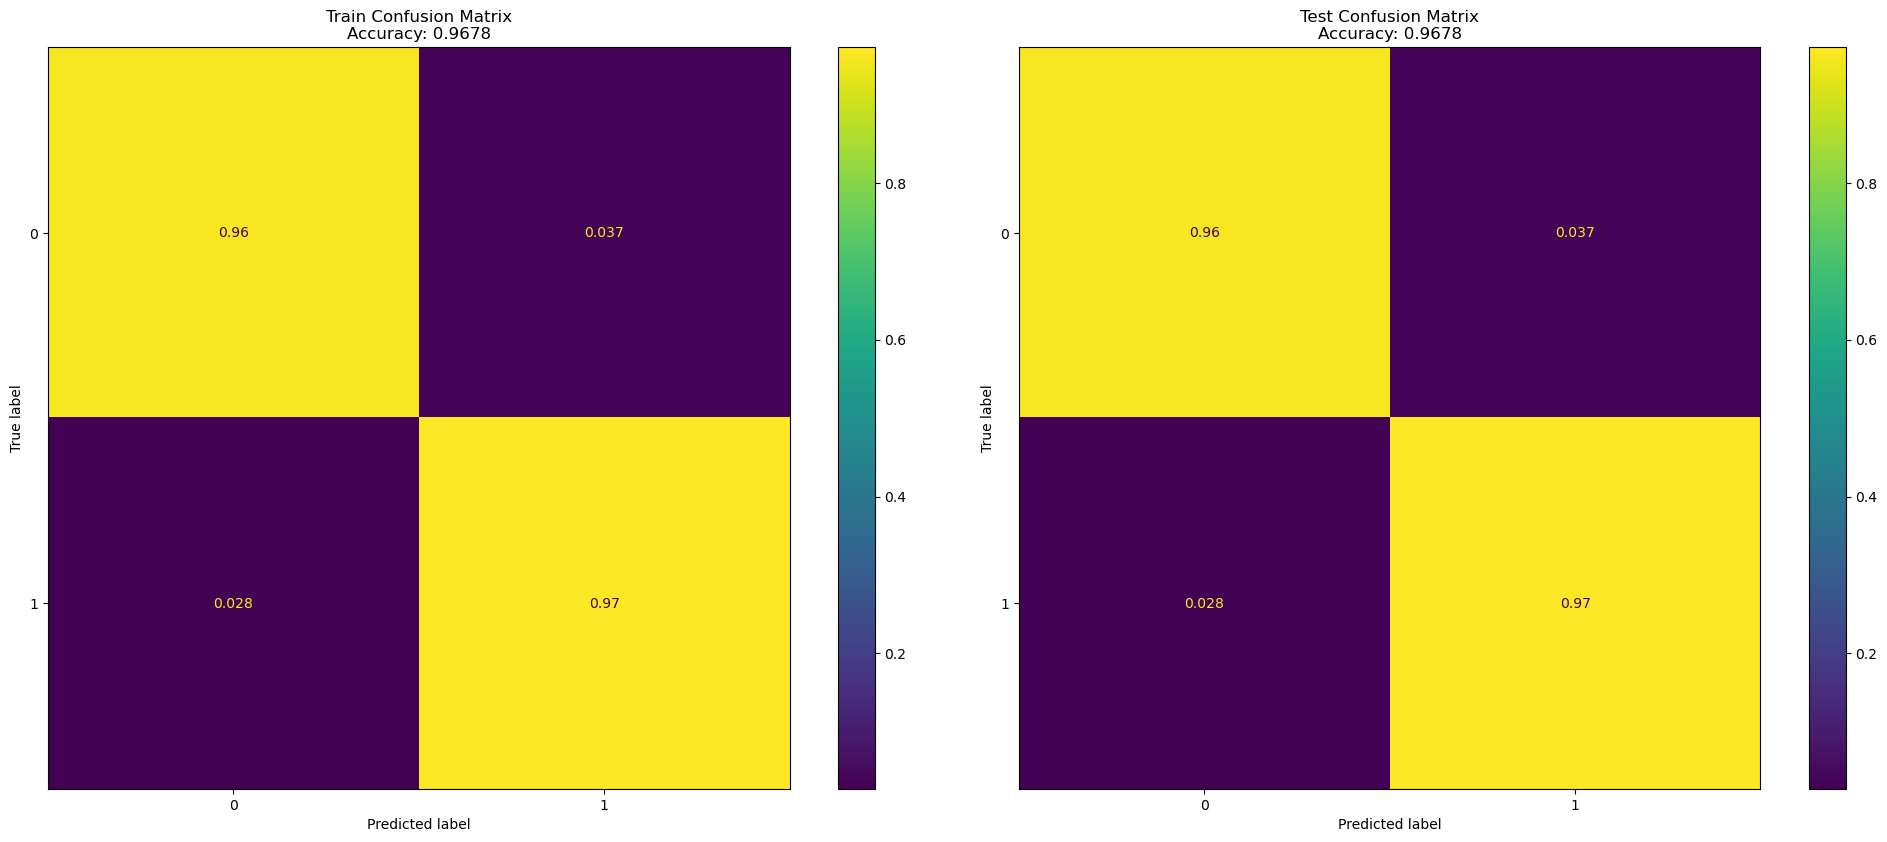

EER = 2.85% at threshold 0.595


In [19]:
evaluate_model('model_attn.keras', train_ds, test_ds)